# Prompt

You have now learned to decompose a time series into seasonal and trend components and to use time series to forecast into the future using statsmodels. In this activity, your goal is to identify a new (to you) time series dataset and build a forecast using a seasonal and trend additive or multiplicative model using statsmodels.

Summarize your findings in an executive brief that explores the following:

Data description: Provide a high-level overview of your data and its timeframe along with general information on your dataset
Forecast: Give a description of the forecast. Describe the period that was projected and what the forecast implies about your data. Be sure to include presentation-ready plots with appropriate labels and titles.
Uncertainty: Discuss the evaluation of your model on testing data, and explore the residuals. Discuss the consequence of this error for your model and forecasts. Is there still structure to uncover?

# Imports

In [31]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

## Data Source
Monthly Water Levels  
- https://tidesandcurrents.noaa.gov/reports.html?type=maxmin&bdate=19800408&edate=20240407&units=standard&datum=MSL&id=9419750&retrieve=Retrieve

## Screengrab
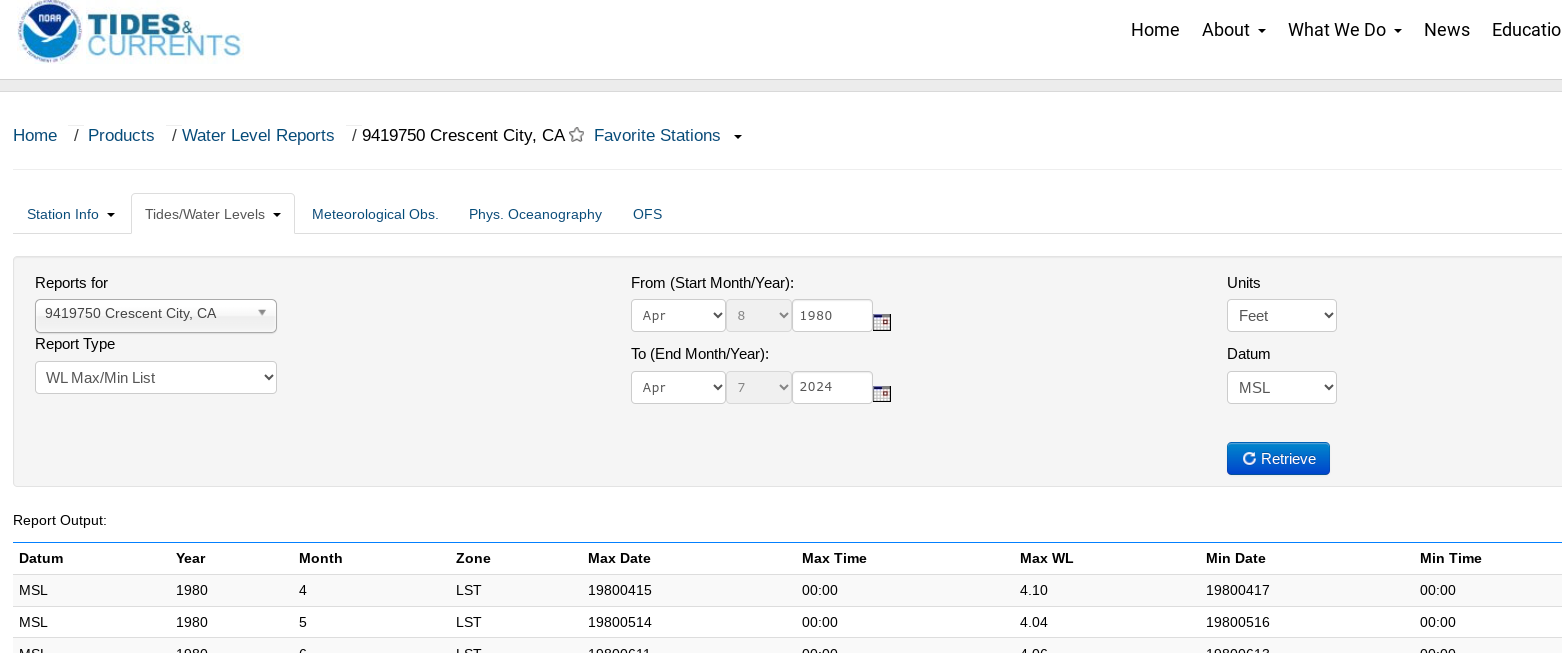

## Data Source
Table Format
- https://tidesandcurrents.noaa.gov/cgi-bin/reports.cgi?type=maxmin&bdate=19800408&datum=MSL&edate=20240407&units=standard&id=9419750&retrieve=&print=1

I took the table format version, copied and pasted into a text file, then fixed a couple of random errors by hand (deleting some random rows)

## Screengrab
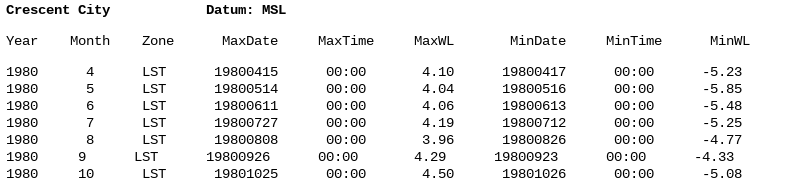

In [ ]:
# plt.plot(tides["MinWL"] - tides["MinWL"].mean(), color="blue", label="MinWL")
# plt.plot(tides["MaxWL"] - tides["MaxWL"].mean(), color="red", label="MaxWL")

In [ ]:
tides = pd.read_csv("./data/noaa_tides_and_currents_report.txt", delim_whitespace=True)
tides

In [ ]:
# tides["Date"] = pd.to_datetime(tides["MinDate"], format="%Y%m%d")
# Ignore the day of month part of date
tides["Date"] = pd.to_datetime(
    tides["MinDate"].apply(lambda x: str(x)[0:6]), format="%Y%m"
)
tides = (
    tides.set_index("Date")
    .drop(
        columns=[
            "Year",
            "Month",
            "Zone",
            "MaxTime",
            "MinDate",
            "MinTime",
            "MaxDate",
            "MaxWL",
        ]
    )
    .rename(columns={"MinWL": "Water Level"})
)

In [ ]:
tides.info()

In [ ]:
tides.head()

# Data Split

In [ ]:
y = tides["Water Level"]

In [ ]:
y.describe()

In [ ]:
(y_history, y_future) = train_test_split(y, shuffle=False)

In [ ]:
[len(y_history), len(y_future)]

# Seasonal Decompose

## Period Search

In [ ]:
plt.plot(y[0:20].to_numpy(), color="blue")

From the above plot it looked like somewhere about 15 months, so run a search to get best

12

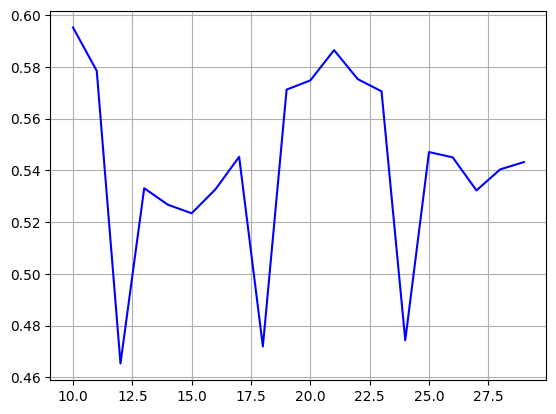

In [27]:
period_guess_list = list(range(10, 30))
errs = []

for period in period_guess_list:
    decomposed = seasonal_decompose(
        y_history,
        model="additive",
        period=period,
        extrapolate_trend=period,
    )

    errs.append(np.sqrt((decomposed.resid**2).mean()))

plt.plot(period_guess_list, errs, "blue")

period = period_guess_list[np.argmin(np.array(errs))]
period

## Fit

In [ ]:
decomposed = seasonal_decompose(
    y_history,
    model="additive",
    period=period,
    extrapolate_trend=period,
)

decomposed.plot()
plt.show()

## Plot

In [ ]:
y_history_modeled = decomposed.trend + decomposed.seasonal

In [ ]:
mae = np.abs(decomposed.resid).mean()
rmse = np.sqrt((decomposed.resid**2).mean())
[mae, rmse]

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(y_history, color="black", label="Observed, History")
plt.plot(y_future, color="black", alpha=0.5, label="Observed, Future")
plt.plot(decomposed.trend, color="red", label="Trend", lw=3)
plt.plot(y_history_modeled, color="blue", label="Model")
plt.title(
    "Minimum Tidal Water Level per Month vs. Time\nModel Errors: MAE = %.2f, RMSE = %.2f"
    % (mae, rmse)
)
plt.xlabel("Year")
plt.ylabel("Water Level (feet, MSL)")
plt.legend(loc="upper left")
plt.show()

# STL and STL Forecast

## Period Search

[6, 18]

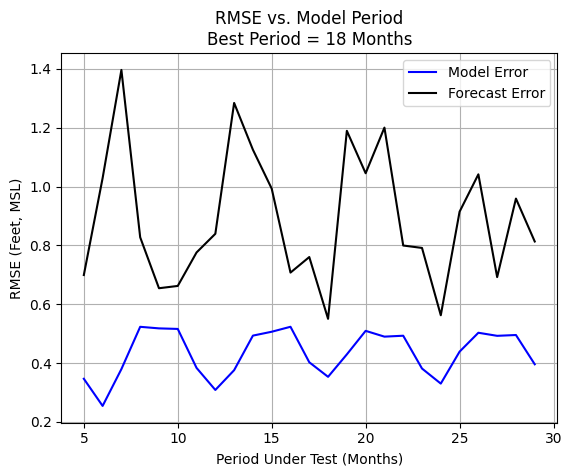

In [60]:
period_guess_list = list(range(5, 30))
errs_fit = []
errs_forecast = []

for period in period_guess_list:
    stl = STL(y_history, period=period).fit()
    stlf = STLForecast(
        y_history, ARIMA, model_kwargs={"order": (1, 1, 0), "trend": "t"}, period=period
    ).fit()
    y_forecast = stlf.forecast(len(y_future))
    y_forecast.index = y_future.index
    errs_fit.append(np.sqrt((stl.resid**2).mean()))
    errs_forecast.append(root_mean_squared_error(y_future, y_forecast))
    # print("Period %2d RMSE Model = %.2f, Forecast = %.2f" % (period, errs_train[-1], errs_forecast[-1]))

best_period_fit = period_guess_list[np.argmin(np.array(errs_fit))]
best_period_forecast = period_guess_list[np.argmin(np.array(errs_forecast))]
period = best_period_forecast

plt.plot(period_guess_list, errs_fit, "blue", label="Model Error")
plt.plot(period_guess_list, errs_forecast, "black", label="Forecast Error")
plt.xlabel("Period Under Test (Months)")
plt.ylabel("RMSE (Feet, MSL)")
plt.title("RMSE vs. Model Period\nBest Period = %d Months" % period)
plt.legend()

display([best_period_train, best_period_forecast])

## Fit and Forecast

In [61]:
stl = STL(y_history, period=period).fit()
stlf = STLForecast(
    y_history, ARIMA, model_kwargs={"order": (1, 1, 0), "trend": "t"}, period=period
).fit()
y_forecast = stlf.forecast(len(y_future))
y_forecast.index = y_future.index

## Plot

In [51]:
y_history_modeled_stl = stl.trend + stl.seasonal

In [64]:
mae_fit = np.abs(stl.resid).mean()
rmse_fit = np.sqrt((stl.resid**2).mean())
mae_forecast = np.abs(y_future - y_forecast).mean()
rmse_forecast = root_mean_squared_error(y_future, y_forecast)

[mae_fit, rmse_fit, mae_forecast, rmse_forecast]

[0.28102250742492596,
 0.3530531406285005,
 0.45295191724206757,
 0.5501423518362768]

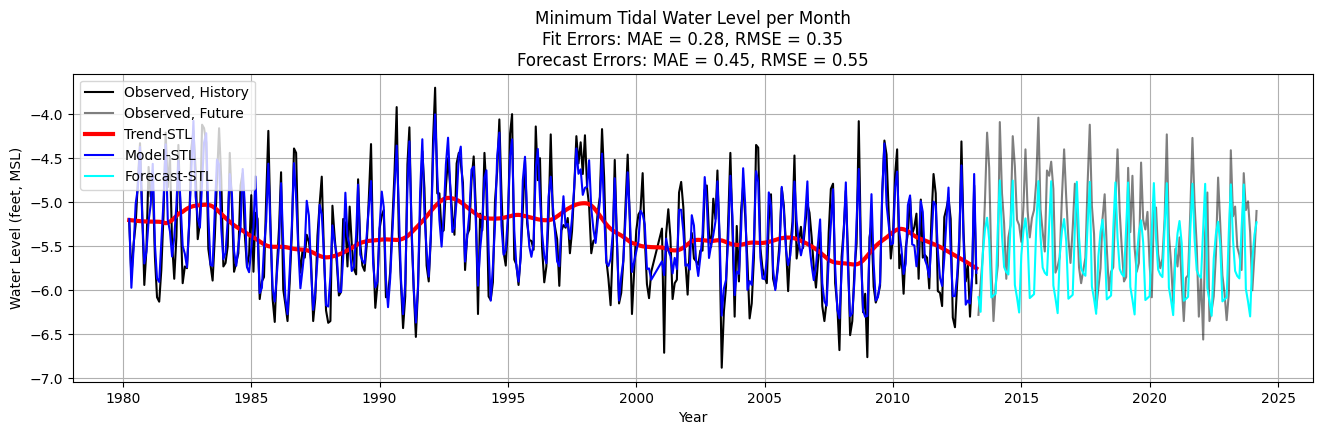

In [73]:
plt.figure(figsize=(16, 4))
plt.plot(y_history, color="black", label="Observed, History")
plt.plot(y_future, color="black", alpha=0.5, label="Observed, Future")
plt.plot(stl.trend, color="red", label="Trend-STL", lw=3)
plt.plot(y_history_modeled_stl, color="blue", label="Model-STL")
plt.plot(y_forecast, color="cyan", label="Forecast-STL")
fit_str = "Fit Errors: MAE = %.2f, RMSE = %.2f" % (mae_fit, rmse_fit)
forecast_str = "Forecast Errors: MAE = %.2f, RMSE = %.2f" % (
    mae_forecast,
    rmse_forecast,
)
plt.title(
    "Minimum Tidal Water Level per Month\n%s\n%s" % (fit_str, forecast_str)
)
plt.xlabel("Year")
plt.ylabel("Water Level (feet, MSL)")
plt.legend(loc="upper left")
plt.show()